In [2]:
import pandas as pd
import random
import numpy as np

# 前処理の方針(探索的データ分析)

- PassengerId(object)      : GroupNumber毎に、グループの人数に置き換え
- HomePlanet(object)       : OneHot
- CryoSleep(object)        : binary(0/1)で置き換える
- Cabin(object)            : 3つのカラムに分割(deck:OneHot or LabelEncoding/num:そのまま使用/side:binary化)
- Destination(object)      : OneHot
- Age(float64)             : 10歳毎にグループ化(子供[0-20]/大人[20-60]/老人[60-])
- VIP(object)              : binary(0/1)で置き換える
- RoomService(float64)     : FoodCourt,ShoppingMall,Spa,VRDeckのsumを一つのカラムとする(ServiceTotal)
- FoodCourt(float64)       : RoomService,ShoppingMall,Spa,VRDeckのsumを一つのカラムとする(ServiceTotal)
- ShoppingMall(float64)    : RoomService,FoodCourt,Spa,VRDeckのsumを一つのカラムとする(ServiceTotal)
- Spa(float64)             : RoomService,FoodCourt,ShoppingMall,VRDeckのsumを一つのカラムとする(ServiceTotal)
- VRDeck(float64)          : RoomService,FoodCourt,ShoppingMall,Spaのsumを一つのカラムとする(ServiceTotal)
- Name(object)             : 除外
- Transported(bool)        : binary(0/1)で置き換える
- ServiceTotal(float64)    : [RoomService,FoodCourt,ShoppingMall,Spa,VRDeck]の合計



# データ取得

In [3]:
# データの中身確認
# データ表示制限設定
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows', 50)
# 学習データ取得
train_df = pd.read_csv('s3://datascience-keigo/kaggle-SpaceshipTitanic/raw/train.csv')
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
# テストデータ取得
test_df = pd.read_csv('s3://datascience-keigo/kaggle-SpaceshipTitanic/raw/test.csv')
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


# 学習データとテストデータ統合

In [5]:
# 学習データとテストデータの統合
all_df = pd.concat([train_df, test_df],sort=False).reset_index(drop=True).copy()
all_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [6]:
# 欠損値の数の確認
all_df.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

# HomePlanetの前処理

In [7]:
# PassengerIdからGroupIdの抽出
all_df['GroupId'] = all_df['PassengerId'].str.split('_').str[0]
all_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273


In [8]:
#HomePlanetの欠損値補完
group_homeplanet_mode = all_df.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
all_df['HomePlanet'] = all_df['HomePlanet'].fillna(group_homeplanet_mode)

In [9]:
# HomePlanetのダミー変数化
all_df = pd.get_dummies(all_df, columns=['HomePlanet'],dtype=int)
all_df

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0,1,0
1,0002_01,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,0,0
2,0003_01,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,0,1,0
3,0003_02,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,0,1,0
4,0004_01,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,1,0,0
12966,9269_01,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,1,0,0
12967,9271_01,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,0,0,1
12968,9273_01,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,0,1,0


# CryoSleepの前処理

In [10]:
# CryoSleepの値がGroupIdごとに一致しているかどうかの確認
b_unique_counts = all_df.groupby('GroupId')['CryoSleep'].nunique()
consistent_groups = b_unique_counts == 1
# 確率（割合）を算出
probability = consistent_groups.mean()
# 各GroupIdごとのPassengerIdの数を取得
group_sizes = all_df.groupby('GroupId')['PassengerId'].count()
# 人数が1人だけのグループをフィルタ
single_member_groups = group_sizes[group_sizes == 1]
# その数を数える
num_single_member_groups = len(single_member_groups)
print(f"人数が1人のグループ数: {num_single_member_groups}")
print(group_sizes)
all_df

人数が1人のグループ数: 7145
GroupId
0001    1
0002    1
0003    2
0004    1
0005    1
       ..
9276    1
9277    1
9278    1
9279    1
9280    2
Name: PassengerId, Length: 9280, dtype: int64


,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0,1,0
1,0002_01,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,0,0
2,0003_01,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,0,1,0
3,0003_02,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,0,1,0
4,0004_01,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,1,0,0
12966,9269_01,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,1,0,0
12967,9271_01,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,0,0,1
12968,9273_01,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,0,1,0


In [11]:
# CryoSleepのバイナリ化
mapping = {True: 1, False: 0}
all_df['CryoSleep'] = all_df['CryoSleep'].map(mapping)
all_df

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,0.0,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0,1,0
1,0002_01,0.0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,0,0
2,0003_01,0.0,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,0,1,0
3,0003_02,0.0,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,0,1,0
4,0004_01,0.0,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,1,0,0
12966,9269_01,0.0,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,1,0,0
12967,9271_01,1.0,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,0,0,1
12968,9273_01,0.0,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,0,1,0


# Cabinの前処理

In [12]:
# Cabinの欠損値補完
group_cabin_mode = all_df.groupby('GroupId')['Cabin'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
all_df['Cabin'] = all_df['Cabin'].fillna(group_cabin_mode)
all_df

# Cabinの分割処理
all_df[['CabinDeck','CabinNum','CabinSide']] = all_df['Cabin'].str.split('/', expand=True)
all_df

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinDeck,CabinNum,CabinSide
0,0001_01,0.0,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0,1,0,B,0,P
1,0002_01,0.0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,0,0,F,0,S
2,0003_01,0.0,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,0,1,0,A,0,S
3,0003_02,0.0,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,0,1,0,A,0,S
4,0004_01,0.0,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,0,0,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,1,0,0,G,1496,S
12966,9269_01,0.0,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,1,0,0,NaN,None,None
12967,9271_01,1.0,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,0,0,1,D,296,P
12968,9273_01,0.0,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,0,1,0,D,297,P


In [13]:
# CabinDeckのダミー変数化
all_df = pd.get_dummies(all_df, columns=['CabinDeck'],dtype=int)

In [14]:
# CabinSideのダミー変数化
# CabinSide_Pを1としてOneHot化
all_df = pd.get_dummies(all_df, columns=['CabinSide'],dtype=int)
all_df['CabinSide'] = all_df['CabinSide_P']

In [15]:
# ダミー変数かされた際に作成された不要なカラムを削除
all_df = all_df.drop(['CabinSide_P','CabinSide_S'],axis=1)
all_df

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide
0,0001_01,0.0,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1
1,0002_01,0.0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0003_01,0.0,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0
3,0003_02,0.0,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0004_01,0.0,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0
12966,9269_01,0.0,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0
12967,9271_01,1.0,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1
12968,9273_01,0.0,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1


In [16]:
# Cabinの削除
all_df = all_df.drop('Cabin',axis=1)
all_df

,PassengerId,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide
0,0001_01,0.0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1
1,0002_01,0.0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0003_01,0.0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0
3,0003_02,0.0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0004_01,0.0,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0
12966,9269_01,0.0,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0
12967,9271_01,1.0,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1
12968,9273_01,0.0,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1


# Destinationの前処理

In [17]:
# Destinationの欠損値補完
group_destination_mode = all_df.groupby('GroupId')['Destination'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
all_df['Destination'] = all_df['Destination'].fillna(group_destination_mode)

In [18]:
# Destinationのダミー変数化
all_df = pd.get_dummies(all_df, columns=['Destination'],dtype=int)
all_df

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0.0,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1
1,0002_01,0.0,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0003_01,0.0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0003_02,0.0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0004_01,0.0,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1
12966,9269_01,0.0,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1
12967,9271_01,1.0,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0
12968,9273_01,0.0,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0


# Service群の前処理

In [19]:
# Service料金の合計カラムの処理
service_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
all_df['ServiceTotal'] = all_df[service_cols].fillna(0).sum(axis=1)
all_df = all_df.drop(service_cols, axis=1)
all_df

,PassengerId,CryoSleep,Age,VIP,Name,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal
0,0001_01,0.0,39.0,False,Maham Ofracculy,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0
1,0002_01,0.0,24.0,False,Juanna Vines,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0
2,0003_01,0.0,58.0,True,Altark Susent,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0
3,0003_02,0.0,33.0,False,Solam Susent,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0
4,0004_01,0.0,16.0,False,Willy Santantines,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,34.0,False,Jeron Peter,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0
12966,9269_01,0.0,42.0,False,Matty Scheron,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0
12967,9271_01,1.0,NaN,False,Jayrin Pore,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0
12968,9273_01,0.0,NaN,False,Kitakan Conale,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0


# Nameの前処理

In [21]:
# Nameの削除
all_df = all_df.drop('Name', axis=1)
all_df

,PassengerId,CryoSleep,Age,VIP,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal
0,0001_01,0.0,39.0,False,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0
1,0002_01,0.0,24.0,False,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0
2,0003_01,0.0,58.0,True,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0
3,0003_02,0.0,33.0,False,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0
4,0004_01,0.0,16.0,False,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,34.0,False,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0
12966,9269_01,0.0,42.0,False,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0
12967,9271_01,1.0,NaN,False,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0
12968,9273_01,0.0,NaN,False,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0


# Ageの前処理

In [25]:
# 年齢カテゴリの定義
bins = [0, 20, 60, float('inf')]
labels = ['Child', 'Adult', 'Senior']
# 年齢をカテゴリに変換（欠損があっても自動でNaNになります）
all_df['Age'] = pd.cut(all_df['Age'], bins=bins, labels=labels, right=False)
# ダミー変数化（one-hot encoding）
all_df = pd.get_dummies(all_df, columns=["Age"],dtype=int)
all_df

,PassengerId,CryoSleep,VIP,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal,Age_Child,Age_Adult,Age_Senior
0,0001_01,0.0,False,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0,0,1,0
1,0002_01,0.0,False,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0,0,1,0
2,0003_01,0.0,True,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0,0,1,0
3,0003_02,0.0,False,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0,0,1,0
4,0004_01,0.0,False,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,False,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0,1,0
12966,9269_01,0.0,False,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0,0,1,0
12967,9271_01,1.0,False,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0,0,0,0
12968,9273_01,0.0,False,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0,0,0,0


# PassengerIdの前処理

In [26]:
# GroupNumへの変換
all_df['GroupNum'] = all_df.groupby('GroupId')['PassengerId'].transform('count')
all_df

,PassengerId,CryoSleep,VIP,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal,Age_Child,Age_Adult,Age_Senior,GroupNum
0,0001_01,0.0,False,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0,0,1,0,1
1,0002_01,0.0,False,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0,0,1,0,1
2,0003_01,0.0,True,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0,0,1,0,2
3,0003_02,0.0,False,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0,0,1,0,2
4,0004_01,0.0,False,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,False,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0,1,0,2
12966,9269_01,0.0,False,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0,0,1,0,1
12967,9271_01,1.0,False,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0,0,0,0,1
12968,9273_01,0.0,False,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0,0,0,0,1


In [28]:
all_df

,PassengerId,CryoSleep,VIP,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal,Age_Child,Age_Adult,Age_Senior,GroupNum
0,0001_01,0.0,False,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0,0,1,0,1
1,0002_01,0.0,False,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0,0,1,0,1
2,0003_01,0.0,True,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0,0,1,0,2
3,0003_02,0.0,False,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0,0,1,0,2
4,0004_01,0.0,False,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1.0,False,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0,1,0,2
12966,9269_01,0.0,False,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0,0,1,0,1
12967,9271_01,1.0,False,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0,0,0,0,1
12968,9273_01,0.0,False,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0,0,0,0,1


In [29]:
# PassengerIdを削除
all_df = all_df.drop('PassengerId',axis=1)
all_df

,CryoSleep,VIP,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal,Age_Child,Age_Adult,Age_Senior,GroupNum
0,0.0,False,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0,0,1,0,1
1,0.0,False,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0,0,1,0,1
2,0.0,True,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0,0,1,0,2
3,0.0,False,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0,0,1,0,2
4,0.0,False,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1.0,False,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0,1,0,2
12966,0.0,False,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0,0,1,0,1
12967,1.0,False,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0,0,0,0,1
12968,0.0,False,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0,0,0,0,1


# 欠損値除外(教師データのみ)

In [33]:
# 学習データ分離
df_train = all_df[~all_df['Transported'].isna()]
df_train

,CryoSleep,VIP,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal,Age_Child,Age_Adult,Age_Senior,GroupNum
0,0.0,False,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0,0,1,0,1
1,0.0,False,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0,0,1,0,1
2,0.0,True,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0,0,1,0,2
3,0.0,False,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0,0,1,0,2
4,0.0,False,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,True,False,9276,0,1,0,98,1,0,0,0,0,0,0,0,1,1,0,0,8536.0,0,1,0,1
8689,1.0,False,False,9278,1,0,0,1499,0,0,0,0,0,0,1,0,0,0,1,0,0.0,1,0,0,1
8690,0.0,False,True,9279,1,0,0,1500,0,0,0,0,0,0,1,0,0,0,0,1,1873.0,0,1,0,1
8691,0.0,False,False,9280,0,1,0,608,0,0,0,0,1,0,0,0,0,1,0,0,4637.0,0,1,0,2


In [32]:
# 検証データ分離
df_test = all_df[all_df['Transported'].isna()]
df_test

,CryoSleep,VIP,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal,Age_Child,Age_Adult,Age_Senior,GroupNum
8693,1.0,False,NaN,0013,1,0,0,3,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0,1,0,1
8694,0.0,False,NaN,0018,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,1,2832.0,1,0,0,1
8695,1.0,False,NaN,0019,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.0,0,1,0,1
8696,0.0,False,NaN,0021,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,7418.0,0,1,0,1
8697,0.0,False,NaN,0023,1,0,0,5,0,0,0,0,0,1,0,0,0,0,0,1,645.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1.0,False,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0,1,0,2
12966,0.0,False,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0,0,1,0,1
12967,1.0,False,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0,0,0,0,1
12968,0.0,False,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0,0,0,0,1


In [36]:
# 教師データの欠損値数確認
df_train.isnull().sum()

CryoSleep                    217
VIP                          203
Transported                    0
GroupId                        0
HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
CabinNum                      99
CabinDeck_A                    0
CabinDeck_B                    0
CabinDeck_C                    0
CabinDeck_D                    0
CabinDeck_E                    0
CabinDeck_F                    0
CabinDeck_G                    0
CabinDeck_T                    0
CabinSide                      0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e        0
ServiceTotal                   0
Age_Child                      0
Age_Adult                      0
Age_Senior                     0
GroupNum                       0
dtype: int64

In [37]:
# 教師データの欠損値除外
df_train = df_train.dropna()

In [38]:
# 欠損値除外後の確認処理
df_train.isnull().sum()

CryoSleep                    0
VIP                          0
Transported                  0
GroupId                      0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CabinNum                     0
CabinDeck_A                  0
CabinDeck_B                  0
CabinDeck_C                  0
CabinDeck_D                  0
CabinDeck_E                  0
CabinDeck_F                  0
CabinDeck_G                  0
CabinDeck_T                  0
CabinSide                    0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
ServiceTotal                 0
Age_Child                    0
Age_Adult                    0
Age_Senior                   0
GroupNum                     0
dtype: int64

In [40]:
# 教師データの欠損値確認
df_train.isnull().sum()

CryoSleep                    0
VIP                          0
Transported                  0
GroupId                      0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CabinNum                     0
CabinDeck_A                  0
CabinDeck_B                  0
CabinDeck_C                  0
CabinDeck_D                  0
CabinDeck_E                  0
CabinDeck_F                  0
CabinDeck_G                  0
CabinDeck_T                  0
CabinSide                    0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
ServiceTotal                 0
Age_Child                    0
Age_Adult                    0
Age_Senior                   0
GroupNum                     0
dtype: int64

In [44]:
# 欠損値削除後の学習データとテストデータの再統合
all_df = pd.concat([df_train, df_test],sort=False).reset_index(drop=True).copy()
all_df

,CryoSleep,VIP,Transported,GroupId,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal,Age_Child,Age_Adult,Age_Senior,GroupNum
0,0.0,False,False,0001,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0,0,1,0,1
1,0.0,False,True,0002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0,0,1,0,1
2,0.0,True,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0,0,1,0,2
3,0.0,False,False,0003,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0,0,1,0,2
4,0.0,False,True,0004,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12458,1.0,False,NaN,9266,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0,1,0,2
12459,0.0,False,NaN,9269,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0,0,1,0,1
12460,1.0,False,NaN,9271,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0,0,0,0,1
12461,0.0,False,NaN,9273,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0,0,0,0,1


In [45]:
# データ統合後の欠損値確認
all_df.isnull().sum()

CryoSleep                      93
VIP                            93
Transported                  4277
GroupId                         0
HomePlanet_Earth                0
HomePlanet_Europa               0
HomePlanet_Mars                 0
CabinNum                       63
CabinDeck_A                     0
CabinDeck_B                     0
CabinDeck_C                     0
CabinDeck_D                     0
CabinDeck_E                     0
CabinDeck_F                     0
CabinDeck_G                     0
CabinDeck_T                     0
CabinSide                       0
Destination_55 Cancri e         0
Destination_PSO J318.5-22       0
Destination_TRAPPIST-1e         0
ServiceTotal                    0
Age_Child                       0
Age_Adult                       0
Age_Senior                      0
GroupNum                        0
dtype: int64

# データ型変換

In [ ]:
# 2025/08/03に要検討
# VIPのバイナリ化処理
all_df['VIP'] = all_df['VIP'].astype(int)
all_df.dtypes

# Transportedのバイナリ化処理
mapping = {True: 1, False: 0}
all_df['Transported'] = all_df['Transported'].map(mapping)
all_df

# 相関行列の作成

In [46]:
# 相関行列用データフレーム作成
new_train_df = all_df[~all_df['Transported'].isnull()].reset_index(drop=True)

<Axes: >

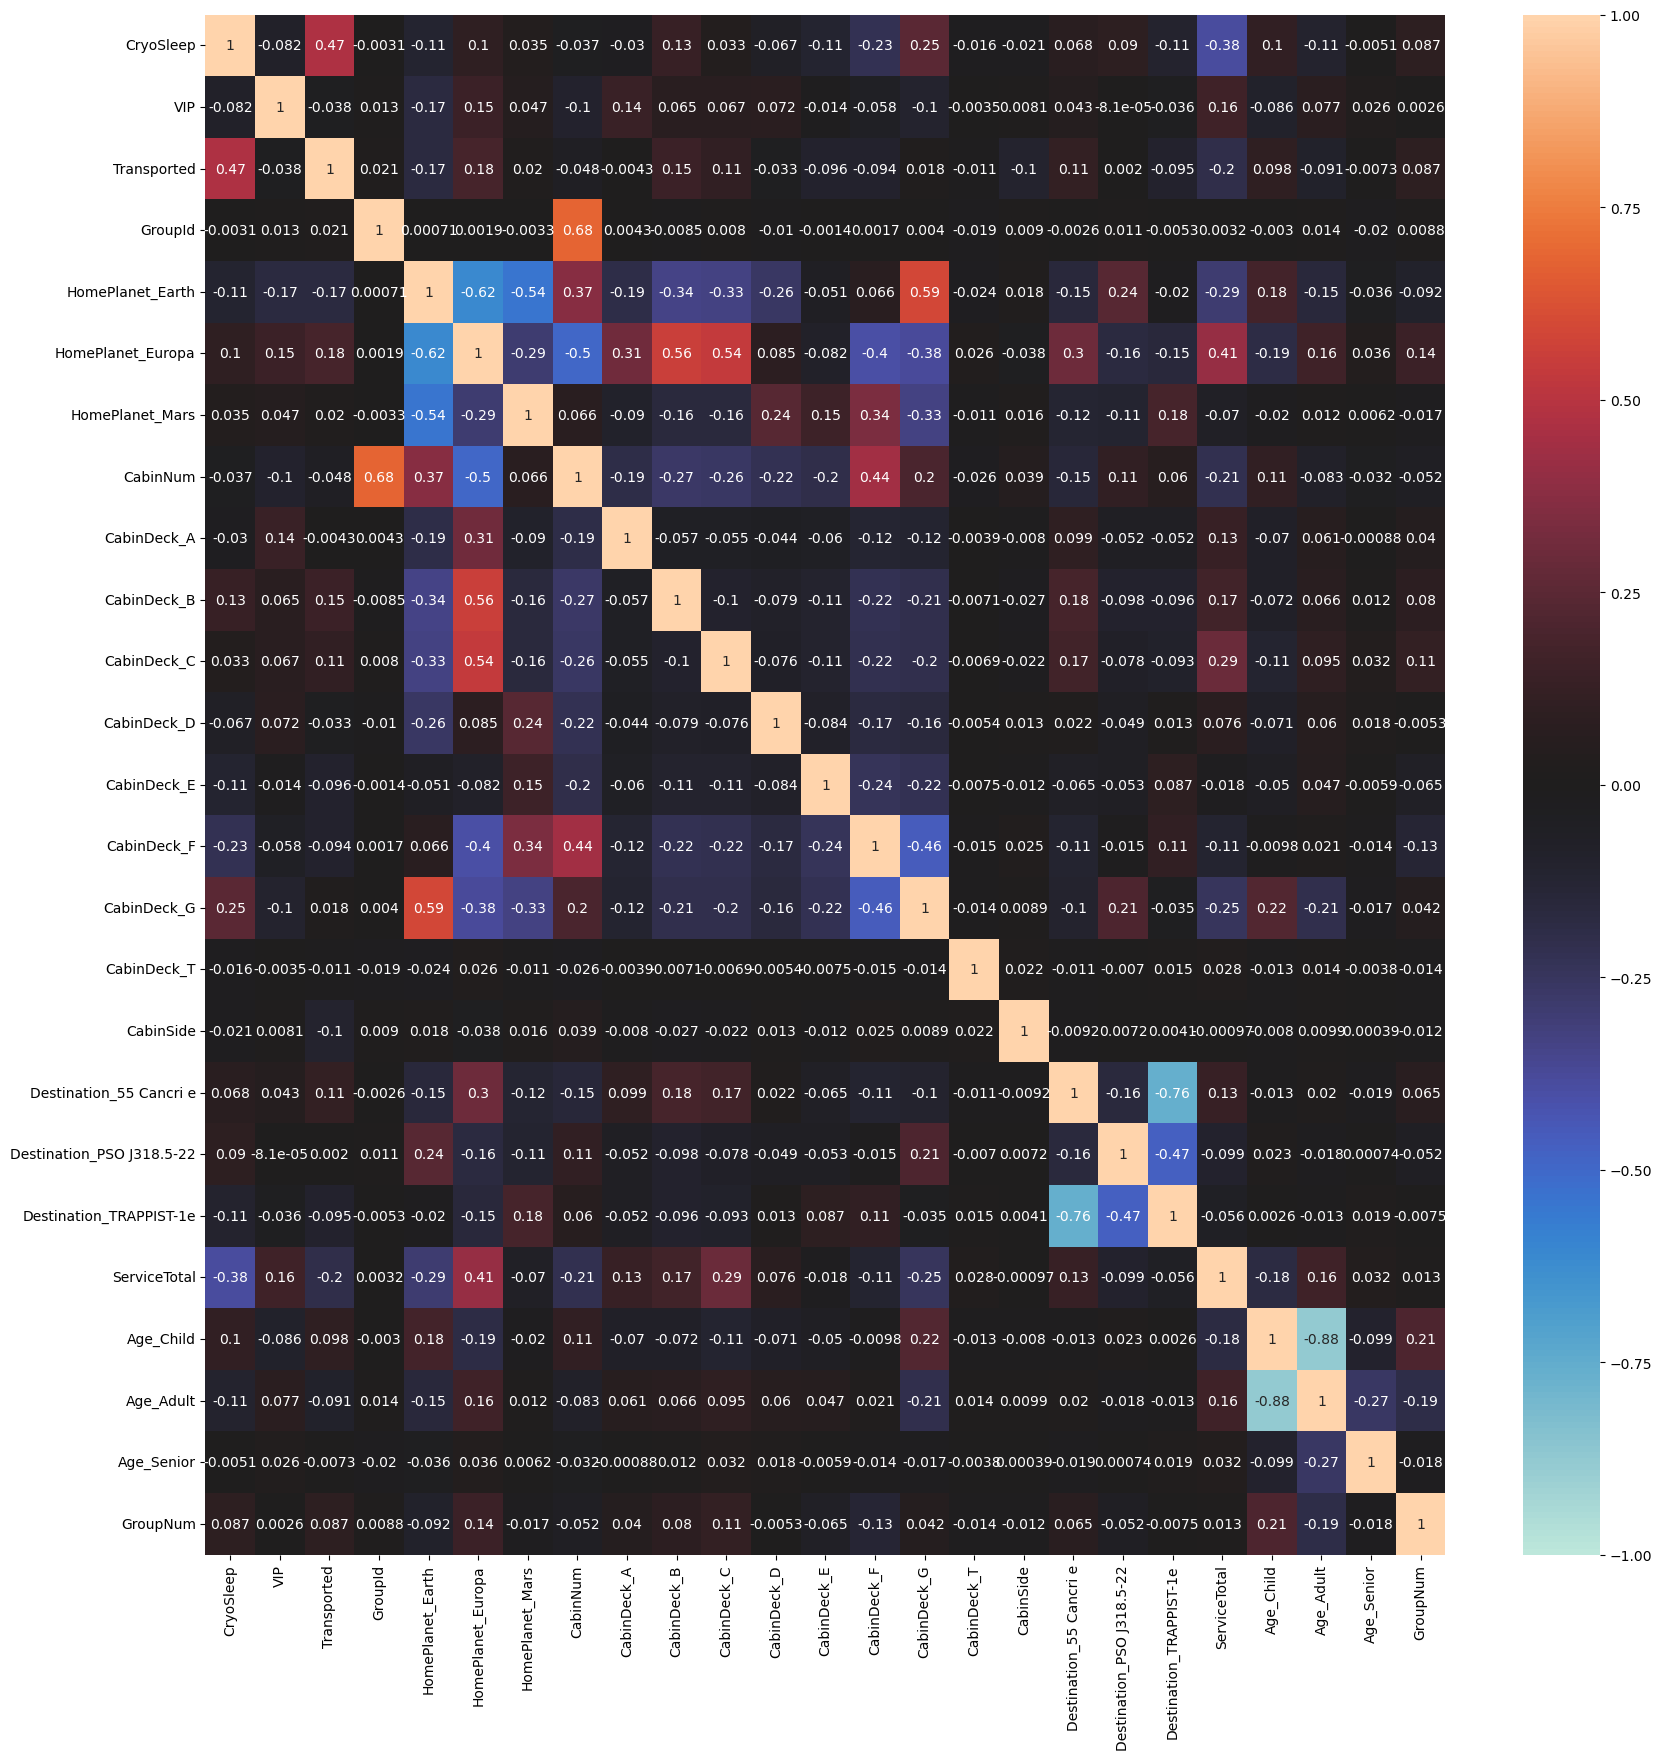

In [47]:
# 教師データの各カラム毎の相関行列をヒートマップで描画
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
train_corr = new_train_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0,annot=True)

In [48]:
# GroupIdの削除
all_df = all_df.drop('GroupId',axis=1)
all_df

,CryoSleep,VIP,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CabinNum,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,ServiceTotal,Age_Child,Age_Adult,Age_Senior,GroupNum
0,0.0,False,False,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0,0,1,0,1
1,0.0,False,True,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,736.0,0,1,0,1
2,0.0,True,False,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10383.0,0,1,0,2
3,0.0,False,False,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5176.0,0,1,0,2
4,0.0,False,True,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1091.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12458,1.0,False,NaN,1,0,0,1496,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0,1,0,2
12459,0.0,False,NaN,1,0,0,None,0,0,0,0,0,0,0,0,0,0,0,1,1018.0,0,1,0,1
12460,1.0,False,NaN,0,0,1,296,0,0,0,1,0,0,0,0,1,1,0,0,0.0,0,0,0,1
12461,0.0,False,NaN,0,1,0,297,0,0,0,1,0,0,0,0,1,0,0,0,3203.0,0,0,0,1


# 教師データとテストデータへ分割

In [49]:
# 教師データとテストデータへ分割
train_X = all_df[~all_df['Transported'].isnull()].drop('Transported',axis=1).reset_index(drop=True)
train_Y = new_train_df['Transported']
test_X = all_df[all_df['Transported'].isnull()].drop('Transported', axis=1).reset_index(drop=True)
train_X.shape

(8186, 23)

In [50]:
train_Y.shape

(8186,)

In [51]:
test_X.shape

(4277, 23)

In [52]:
# CrossValidation用のデータ分割設定処理
from sklearn.model_selection import KFold
folds=3
kf = KFold(n_splits=folds)

In [53]:
# CrossValidation用のデータ分割処理
X_train = []
X_valid = []
Y_train = []
Y_valid = []
for train_index, val_index in kf.split(train_X):
    X_train.append(train_X.iloc[train_index])
    X_valid.append(train_X.iloc[val_index])
    Y_train.append(train_Y.iloc[train_index])
    Y_valid.append(train_Y.iloc[val_index])

In [54]:
import pickle
# pickleファイルを出力
with open("X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("Y_train.pkl", "wb") as f:
    pickle.dump(Y_train, f)
with open("X_valid.pkl", "wb") as f:
    pickle.dump(X_valid, f)
with open("Y_valid.pkl", "wb") as f:
    pickle.dump(Y_valid, f)
with open("test_X.pkl", "wb") as f:
    pickle.dump(test_X, f)

In [55]:
import boto3
from urllib.parse import urlparse

def upload_file_to_s3(s3_uri_dir, local_file_path):
    # ファイル名だけ抽出（例: X_train.pickle）
    file_name = local_file_path.split("/")[-1]

    # S3 URIからバケット名とキー（パス）を抽出
    parsed = urlparse(s3_uri_dir)
    bucket = parsed.netloc
    prefix = parsed.path.lstrip("/")  # 先頭の / を削除
    key = f"{prefix.rstrip('/')}/{file_name}"  # フルキー

    # S3へアップロード
    s3 = boto3.client("s3")
    s3.upload_file(local_file_path, bucket, key)

    print(f"✅ アップロード完了: s3://{bucket}/{key}")

# Pickleファイルをs3へアップロード
upload_file_to_s3(
    s3_uri_dir="s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/",
    local_file_path="X_train.pkl"
)
upload_file_to_s3(
    s3_uri_dir="s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/",
    local_file_path="Y_train.pkl"
)
upload_file_to_s3(
    s3_uri_dir="s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/",
    local_file_path="X_valid.pkl"
)
upload_file_to_s3(
    s3_uri_dir="s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/",
    local_file_path="Y_valid.pkl"
)
upload_file_to_s3(
    s3_uri_dir="s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/",
    local_file_path="test_X.pkl"
)

✅ アップロード完了: s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/X_train.pkl
✅ アップロード完了: s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/Y_train.pkl
✅ アップロード完了: s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/X_valid.pkl
✅ アップロード完了: s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/Y_valid.pkl
✅ アップロード完了: s3://datascience-keigo/kaggle-SpaceshipTitanic/processed/CV_1/test_X.pkl
